## Prétraitement

In [72]:
import sys
sys.path.insert(0, '../')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from src.data import load_data_excel, convert_numeric_columns
from src.features import onehot_encode_categorical_feature, get_simplified_names
from src.experiments import (
    prepare_data_random_split, train_xgboost_models
)
from src.visu import plot_ml_results

# Load data
data = load_data_excel('../data/sources/Donnees_IA_2025.xlsx')

# Define variables
vars_expl = [
    "MS % brut", "PB % brut", "CB % brut", "MGR % brut", "MM % brut",
    "NDF % brut", "ADF % brut", "Lignine % brut", "Amidon % brut", "Sucres % brut"
]

vars_cibles = [
    "EB (kcal) kcal/kg brut", "ED porc croissance (kcal) kcal/kg brut",
    "EM porc croissance (kcal) kcal/kg brut", "EN porc croissance (kcal) kcal/kg brut",
    "EMAn coq (kcal) kcal/kg brut", "EMAn poulet (kcal) kcal/kg brut",
    "UFL 2018 par kg brut", "UFV 2018 par kg brut", "PDIA 2018 g/kg brut",
    "PDI 2018 g/kg brut", "BalProRu 2018 g/kg brut"
]

# Convert numeric columns
data = convert_numeric_columns(data, vars_expl + vars_cibles)

# Get simplified names
simplified_names = get_simplified_names()

print(f" Data loaded: {len(data)} observations")

 Data loaded: 6376 observations


## Régression XGBoost et test sur les valeurs de table (In Distribution) - Importance des caractéristiques et test de robustesse

Testez comment les performances du modèle varient en fonction des différentes caractéristiques d'entrée et des encodages catégoriels.

### Scenario 1: Toutes les variables physico-chimiques (sans encodage catégoriel)

In [73]:
# Prepare data with random split
X_train_all, X_test_all, y_train_all, y_test_all = prepare_data_random_split(
    data, vars_expl, vars_cibles, test_size=0.2, random_state=42
)

# Train XGBoost models
results_all, metrics_all, models_all = train_xgboost_models(
    X_train_all, X_test_all, y_train_all, y_test_all,
    vars_cibles, simplified_names, random_state=42
)

print("\nScenario 1: All Chemical Composition Variables")
print(f"Train size: {len(X_train_all)}, Test size: {len(X_test_all)}")
print(f"R² variance weighted: {metrics_all['R2_variance_weighted']:.4f}")
print(f"R² uniform: {metrics_all['R2_uniform']:.4f}")
print(f"R² min: {metrics_all['R2_min']:.4f}")
print("\nDetailed results:")
print(results_all[['Variable cible', 'R2', 'MAE', 'RMSE']].to_string(index=False))


Scenario 1: All Chemical Composition Variables
Train size: 5100, Test size: 1276
R² variance weighted: 0.9899
R² uniform: 0.9903
R² min: 0.9879

Detailed results:
Variable cible     R2   MAE  RMSE
            EB 0.9928 31.02 52.96
       ED porc 0.9879 49.31 93.01
       EM porc 0.9892 45.48 84.46
       EN porc 0.9933 35.00 58.44
      EMAn coq 0.9895 48.93 82.59
   EMAn poulet 0.9883 49.61 84.54
           UFL 0.9899  0.02  0.03
           UFV 0.9880  0.02  0.04
          PDIA 0.9906  2.73  8.02
           PDI 0.9900  2.77  8.13
      BalProRu 0.9939  3.35  7.53


### Scenario 2: Varibales MS et PB uniquement (variables les plus couramment connues par les utilisateurs)

In [74]:
# Scenario 2: Reduced features
features_reduced = ["MS % brut", "PB % brut"]
X_train_reduced, X_test_reduced, y_train_reduced, y_test_reduced = prepare_data_random_split(
    data, features_reduced, vars_cibles, test_size=0.2, random_state=42
)

results_reduced, metrics_reduced, models_reduced = train_xgboost_models(
    X_train_reduced, X_test_reduced, y_train_reduced, y_test_reduced,
    vars_cibles, simplified_names, random_state=42
)

print("\nScenario 2: MS + PB Only")
print(f"Train size: {len(X_train_reduced)}, Test size: {len(X_test_reduced)}")
print(f"R² variance weighted: {metrics_reduced['R2_variance_weighted']:.4f}")
print(f"Performance drop vs all features: {metrics_all['R2_variance_weighted'] - metrics_reduced['R2_variance_weighted']:+.4f}")
print(results_reduced[['Variable cible', 'R2', 'MAE', 'RMSE']].to_string(index=False))


Scenario 2: MS + PB Only
Train size: 5100, Test size: 1276
R² variance weighted: 0.4208
Performance drop vs all features: +0.5691
Variable cible     R2    MAE   RMSE
            EB 0.6596 225.91 364.43
       ED porc 0.4855 411.00 607.56
       EM porc 0.4392 412.11 609.83
       EN porc 0.3650 377.90 569.02
      EMAn coq 0.3147 451.91 667.24
   EMAn poulet 0.3139 440.80 647.38
           UFL 0.4336   0.14   0.22
           UFV 0.4058   0.17   0.25
          PDIA 0.8875  15.37  27.80
           PDI 0.8854  15.28  27.57
      BalProRu 0.9105  16.96  28.96


### Scenario 3: Nom Only (One-Hot Encoded)

In [75]:
# Scenario 3: Nom only (One-Hot Encoded)
X_train_nom_ohe, X_test_nom_ohe, y_train_nom_ohe, y_test_nom_ohe = prepare_data_random_split(
    data, [], vars_cibles, test_size=0.2, random_state=42
)

# Keep track of indices for one-hot encoding
indices_train_nom = X_train_nom_ohe.index
indices_test_nom = X_test_nom_ohe.index

# Add one-hot encoded Nom feature
X_train_nom_ohe, X_test_nom_ohe = onehot_encode_categorical_feature(
    X_train_nom_ohe, X_test_nom_ohe, data, "Nom", indices_train_nom, indices_test_nom, drop_first=False
)

# Clean column names to remove special characters
X_train_nom_ohe.columns = X_train_nom_ohe.columns.str.replace('[', '_', regex=False).str.replace(']', '_', regex=False).str.replace('<', '_', regex=False)
X_test_nom_ohe.columns = X_test_nom_ohe.columns.str.replace('[', '_', regex=False).str.replace(']', '_', regex=False).str.replace('<', '_', regex=False)

results_nom_ohe, metrics_nom_ohe, models_nom_ohe = train_xgboost_models(
    X_train_nom_ohe, X_test_nom_ohe, y_train_nom_ohe, y_test_nom_ohe,
    vars_cibles, simplified_names, random_state=42
)

print("\nScenario 3: Nom Only (One-Hot Encoded)")
print(f"Train size: {len(X_train_nom_ohe)}, Test size: {len(X_test_nom_ohe)}")
print(f"R² variance weighted: {metrics_nom_ohe['R2_variance_weighted']:.4f}")
print(f"Number of features (One-Hot encoded Nom): {X_train_nom_ohe.shape[1]}")
print(results_nom_ohe[['Variable cible', 'R2', 'MAE', 'RMSE']].to_string(index=False))


Scenario 3: Nom Only (One-Hot Encoded)
Train size: 5100, Test size: 1276
R² variance weighted: 0.9333
Number of features (One-Hot encoded Nom): 73
Variable cible     R2    MAE   RMSE
            EB 0.9379 102.12 155.62
       ED porc 0.9267 144.08 229.35
       EM porc 0.9265 138.04 220.79
       EN porc 0.9411 108.44 173.34
      EMAn coq 0.9355 127.78 204.76
   EMAn poulet 0.9354 123.71 198.58
           UFL 0.9419   0.04   0.07
           UFV 0.9432   0.05   0.08
          PDIA 0.9826   5.54  10.94
           PDI 0.9804   5.86  11.41
      BalProRu 0.9612  11.65  19.06


### Comparative Results

In [76]:
# Create comparison DataFrame for first 3 scenarios
comparison_df = pd.DataFrame({
    'Scenario': [
        'Toutes les variables physico-chimiques',
        'Seules MS + PB',
        'Nom Only (OHE)'
    ],
    'R² Variance Weighted': [
        metrics_all['R2_variance_weighted'],
        metrics_reduced['R2_variance_weighted'],
        metrics_nom_ohe['R2_variance_weighted']
    ],
    'R² Std Dev': [
        results_all['R2'].std(),
        results_reduced['R2'].std(),
        results_nom_ohe['R2'].std()
    ]
})


Table de comparaison des performances (R² Variance Weighted) pour les 3 premiers scénarios :
                              Scenario  R² Variance Weighted  R² Std Dev
Toutes les variables physico-chimiques                0.9899    0.002132
                        Seules MS + PB                0.4208    0.237540
                        Nom Only (OHE)                0.9333    0.019596


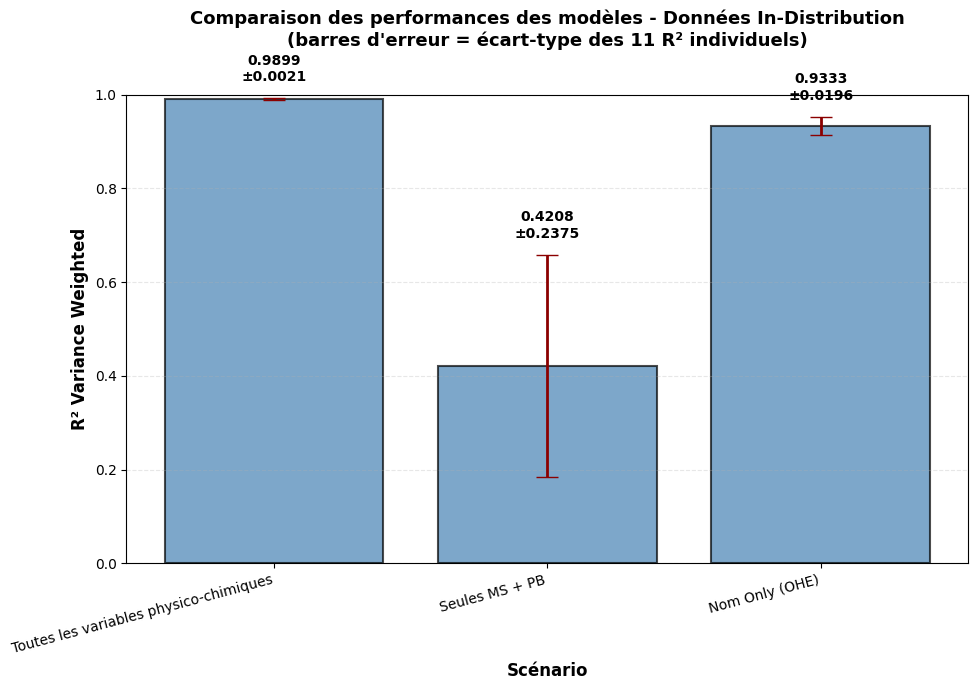

In [77]:

print("\n" + "="*80)
print("Table de comparaison des performances (R² Variance Weighted) pour les 3 premiers scénarios :")
print("="*80)
print(comparison_df.to_string(index=False))

# Plot with error bars showing std dev of R² across 11 targets
fig, ax = plt.subplots(figsize=(10, 7))

x_pos = np.arange(len(comparison_df))
ax.bar(x_pos, comparison_df['R² Variance Weighted'], 
       yerr=comparison_df['R² Std Dev'],
       capsize=8, alpha=0.7, color='steelblue', edgecolor='black', linewidth=1.5,
       error_kw={'linewidth': 2, 'ecolor': 'darkred'})

ax.set_ylabel('R² Variance Weighted', fontsize=12, fontweight='bold')
ax.set_xlabel('Scénario', fontsize=12, fontweight='bold')
ax.set_title('Comparaison des performances des modèles - Données In-Distribution\n(barres d\'erreur = écart-type des 11 R² individuels)', 
             fontsize=13, fontweight='bold', pad=35)
ax.set_xticks(x_pos)
ax.set_xticklabels(comparison_df['Scenario'], rotation=15, ha='right')
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.set_ylim(0, 1)

# Add value labels on bars
for i, (val, std) in enumerate(zip(comparison_df['R² Variance Weighted'], comparison_df['R² Std Dev'])):
    ax.text(i, val + std + 0.03, f'{val:.4f}\n±{std:.4f}', 
            ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

### Scenario 4: Classe Only (Encoded)

In [79]:
# Scenario 4: Classe only (One-Hot Encoded)
X_train_classe, X_test_classe, y_train_classe, y_test_classe = prepare_data_random_split(
    data, [], vars_cibles, test_size=0.2, random_state=42
)

# Keep track of indices for one-hot encoding
indices_train_c = X_train_classe.index
indices_test_c = X_test_classe.index

# Add one-hot encoded Classe feature
X_train_classe, X_test_classe = onehot_encode_categorical_feature(
    X_train_classe, X_test_classe, data, "Classe", indices_train_c, indices_test_c, drop_first=False
)

# Clean column names to remove special characters
X_train_classe.columns = X_train_classe.columns.str.replace('[', '_', regex=False).str.replace(']', '_', regex=False).str.replace('<', '_', regex=False)
X_test_classe.columns = X_test_classe.columns.str.replace('[', '_', regex=False).str.replace(']', '_', regex=False).str.replace('<', '_', regex=False)

results_classe, metrics_classe, models_classe = train_xgboost_models(
    X_train_classe, X_test_classe, y_train_classe, y_test_classe,
    vars_cibles, simplified_names, random_state=42
)

print("\nScenario 4: Classe Only (One-Hot Encoded)")
print(f"Train size: {len(X_train_classe)}, Test size: {len(X_test_classe)}")
print(f"R² variance weighted: {metrics_classe['R2_variance_weighted']:.4f}")
print(f"Number of features (One-Hot encoded Classe): {X_train_classe.shape[1]}")
print(results_classe[['Variable cible', 'R2', 'MAE', 'RMSE']].to_string(index=False))


Scenario 4: Classe Only (One-Hot Encoded)
Train size: 5100, Test size: 1276
R² variance weighted: 0.4393
Number of features (One-Hot encoded Classe): 15
Variable cible     R2    MAE   RMSE
            EB 0.4871 328.57 447.32
       ED porc 0.4274 495.93 640.94
       EM porc 0.4367 475.49 611.22
       EN porc 0.4957 396.26 507.10
      EMAn coq 0.4184 486.85 614.69
   EMAn poulet 0.3997 483.06 605.53
           UFL 0.4719   0.16   0.21
           UFV 0.4730   0.18   0.24
          PDIA 0.4795  36.49  59.80
           PDI 0.4691  36.53  59.33
      BalProRu 0.4790  48.81  69.86


### Scenario 5: Toutes les variables chimiques + Nom (Encodés)

In [80]:
# Scenario 5: All chemical features + Nom (One-Hot Encoded)
X_train_nom, X_test_nom, y_train_nom, y_test_nom = prepare_data_random_split(
    data, vars_expl, vars_cibles, test_size=0.2, random_state=42
)

# Keep track of indices for one-hot encoding
indices_train_nom = X_train_nom.index
indices_test_nom = X_test_nom.index

# Add one-hot encoded Nom feature
X_train_nom, X_test_nom = onehot_encode_categorical_feature(
    X_train_nom, X_test_nom, data, "Nom", indices_train_nom, indices_test_nom, drop_first=False
)

# Clean column names to remove special characters
X_train_nom.columns = X_train_nom.columns.str.replace('[', '_', regex=False).str.replace(']', '_', regex=False).str.replace('<', '_', regex=False)
X_test_nom.columns = X_test_nom.columns.str.replace('[', '_', regex=False).str.replace(']', '_', regex=False).str.replace('<', '_', regex=False)

results_nom, metrics_nom, models_nom = train_xgboost_models(
    X_train_nom, X_test_nom, y_train_nom, y_test_nom,
    vars_cibles, simplified_names, random_state=42
)

print("\nScenario 5: All Chemical Features + Nom (One-Hot Encoded)")
print(f"Train size: {len(X_train_nom)}, Test size: {len(X_test_nom)}")
print(f"R² variance weighted: {metrics_nom['R2_variance_weighted']:.4f}")
print(f"Number of features (Chemical + One-Hot encoded Nom): {X_train_nom.shape[1]}")
print(results_nom[['Variable cible', 'R2', 'MAE', 'RMSE']].to_string(index=False))


Scenario 5: All Chemical Features + Nom (One-Hot Encoded)
Train size: 5100, Test size: 1276
R² variance weighted: 0.9914
Number of features (Chemical + One-Hot encoded Nom): 83
Variable cible     R2   MAE  RMSE
            EB 0.9931 30.21 51.78
       ED porc 0.9915 46.73 78.28
       EM porc 0.9903 44.47 80.26
       EN porc 0.9944 33.63 53.53
      EMAn coq 0.9901 49.05 80.26
   EMAn poulet 0.9904 46.46 76.77
           UFL 0.9894  0.02  0.03
           UFV 0.9908  0.02  0.03
          PDIA 0.9954  1.87  5.60
           PDI 0.9940  2.12  6.30
      BalProRu 0.9966  2.69  5.64


### Scenario 6: MS + PB + Nom (Encoded)

In [81]:
# Scenario 6: MS + PB + Nom (One-Hot Encoded)
features_mspb = ["MS % brut", "PB % brut"]
X_train_mspb_nom, X_test_mspb_nom, y_train_mspb_nom, y_test_mspb_nom = prepare_data_random_split(
    data, features_mspb, vars_cibles, test_size=0.2, random_state=42
)

# Keep track of indices for one-hot encoding
indices_train_mspb = X_train_mspb_nom.index
indices_test_mspb = X_test_mspb_nom.index

# Add one-hot encoded Nom feature
X_train_mspb_nom, X_test_mspb_nom = onehot_encode_categorical_feature(
    X_train_mspb_nom, X_test_mspb_nom, data, "Nom", indices_train_mspb, indices_test_mspb, drop_first=False
)

# Clean column names to remove special characters
X_train_mspb_nom.columns = X_train_mspb_nom.columns.str.replace('[', '_', regex=False).str.replace(']', '_', regex=False).str.replace('<', '_', regex=False)
X_test_mspb_nom.columns = X_test_mspb_nom.columns.str.replace('[', '_', regex=False).str.replace(']', '_', regex=False).str.replace('<', '_', regex=False)

results_mspb_nom, metrics_mspb_nom, models_mspb_nom = train_xgboost_models(
    X_train_mspb_nom, X_test_mspb_nom, y_train_mspb_nom, y_test_mspb_nom,
    vars_cibles, simplified_names, random_state=42
)

print("\nScenario 6: MS + PB + Nom (One-Hot Encoded)")
print(f"Train size: {len(X_train_mspb_nom)}, Test size: {len(X_test_mspb_nom)}")
print(f"R² variance weighted: {metrics_mspb_nom['R2_variance_weighted']:.4f}")
print(f"Number of features (MS + PB + One-Hot encoded Nom): {X_train_mspb_nom.shape[1]}")
print(results_mspb_nom[['Variable cible', 'R2', 'MAE', 'RMSE']].to_string(index=False))


Scenario 6: MS + PB + Nom (One-Hot Encoded)
Train size: 5100, Test size: 1276
R² variance weighted: 0.9648
Number of features (MS + PB + One-Hot encoded Nom): 75
Variable cible     R2    MAE   RMSE
            EB 0.9669  67.65 113.59
       ED porc 0.9645 106.44 159.62
       EM porc 0.9632 103.42 156.12
       EN porc 0.9664  84.95 130.90
      EMAn coq 0.9631  99.96 154.91
   EMAn poulet 0.9650  95.85 146.16
           UFL 0.9677   0.03   0.05
           UFV 0.9678   0.04   0.06
          PDIA 0.9982   1.41   3.52
           PDI 0.9981   1.65   3.52
      BalProRu 0.9986   2.21   3.59


### Comparaison total des différents scénarios

In [82]:
# Extended comparison with all 6 scenarios
comparison_all_df = pd.DataFrame({
    'Scenario': [
        'Tout physicio-chimique',
        'Seules MS + PB',
        'Nom uniquement (OHE)',
        'Classe uniquement (OHE)',
        'Total (Noms + physico-chimiques)',
        'MS + PB + Nom (OHE)'
    ],
    'R² Variance Weighted': [
        metrics_all['R2_variance_weighted'],
        metrics_reduced['R2_variance_weighted'],
        metrics_nom_ohe['R2_variance_weighted'],
        metrics_classe['R2_variance_weighted'],
        metrics_nom['R2_variance_weighted'],
        metrics_mspb_nom['R2_variance_weighted']
    ],
    'R² Std Dev': [
        results_all['R2'].std(),
        results_reduced['R2'].std(),
        results_nom_ohe['R2'].std(),
        results_classe['R2'].std(),
        results_nom['R2'].std(),
        results_mspb_nom['R2'].std()
    ]
})

# Sort by R² in descending order (highest to lowest)
comparison_all_df = comparison_all_df.sort_values('R² Variance Weighted', ascending=False).reset_index(drop=True)


EXTENDED COMPARISON TABLE - All 6 Scenarios (sorted by R² descending)
                        Scenario  R² Variance Weighted  R² Std Dev
Total (Noms + physico-chimiques)                0.9914    0.002444
          Tout physicio-chimique                0.9899    0.002132
             MS + PB + Nom (OHE)                0.9648    0.015368
            Nom uniquement (OHE)                0.9333    0.019596
         Classe uniquement (OHE)                0.4393    0.031733
                  Seules MS + PB                0.4208    0.237540


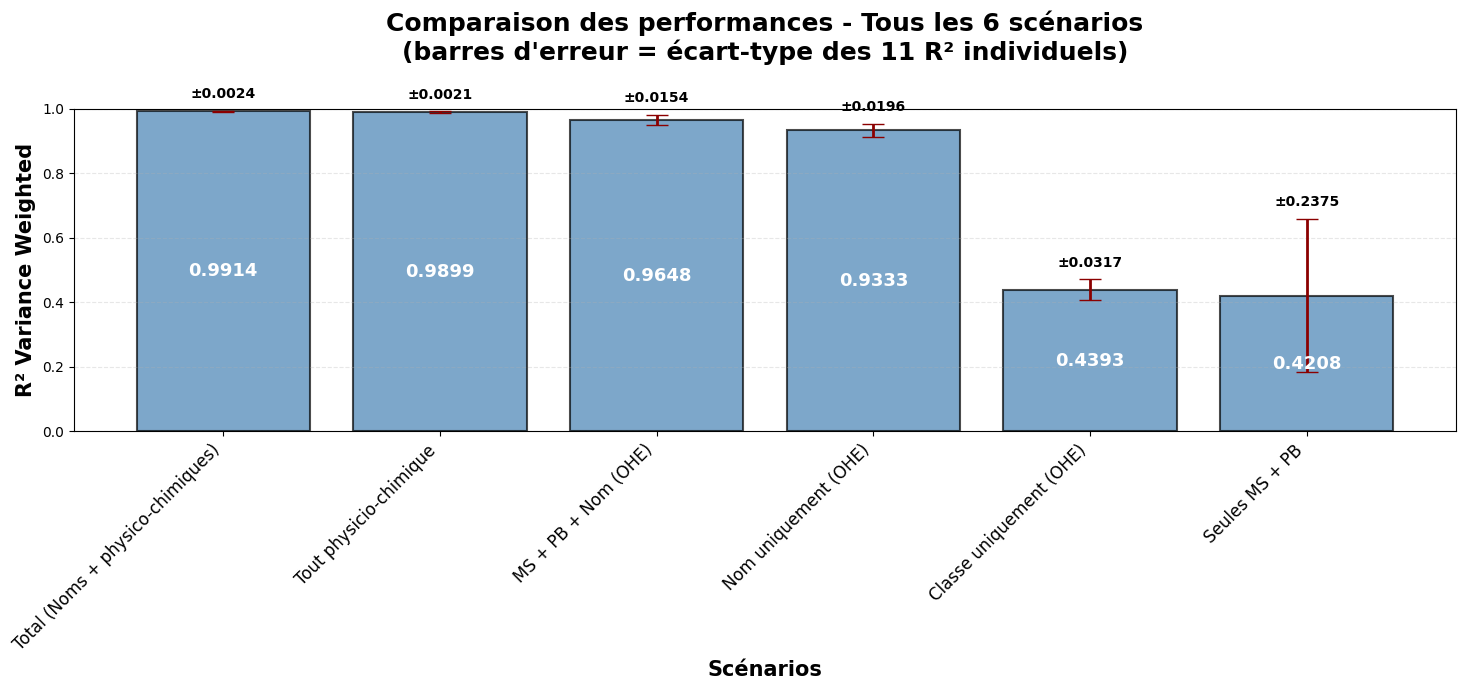

In [89]:

print("\n" + "="*80)
print("EXTENDED COMPARISON TABLE - All 6 Scenarios (sorted by R² descending)")
print("="*80)
print(comparison_all_df.to_string(index=False))

# Plot all 6 scenarios with error bars
fig, ax = plt.subplots(figsize=(15, 7))

x_pos = np.arange(len(comparison_all_df))
ax.bar(x_pos, comparison_all_df['R² Variance Weighted'], 
       yerr=comparison_all_df['R² Std Dev'],
       capsize=8, alpha=0.7, color='steelblue', edgecolor='black', linewidth=1.5,
       error_kw={'linewidth': 2, 'ecolor': 'darkred'})

ax.set_ylabel('R² Variance Weighted', fontsize=15, fontweight='bold')
ax.set_xlabel('Scénarios', fontsize=15, fontweight='bold')
ax.set_title('Comparaison des performances - Tous les 6 scénarios\n(barres d\'erreur = écart-type des 11 R² individuels)', 
             fontsize=18, fontweight='bold', pad=35)
ax.set_xticks(x_pos)
ax.set_xticklabels(comparison_all_df['Scenario'], fontsize=12, rotation=45, ha='right')
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.set_ylim(0, 1)

# Add value labels on bars (WHITE TEXT INSIDE BARS)
for i, (val, std) in enumerate(zip(comparison_all_df['R² Variance Weighted'], comparison_all_df['R² Std Dev'])):
    # Text inside the bar (white)
    ax.text(i, val/2, f'{val:.4f}', 
            ha='center', va='center', fontsize=13, fontweight='bold', color='white')
    # Text above the bar (black, for error info)
    ax.text(i, val + std + 0.03, f'±{std:.4f}', 
            ha='center', va='bottom', fontsize=10, fontweight='bold', color='black')

plt.tight_layout()
plt.savefig('../reports/figures/comparison_all_scenarios.png')
plt.show()

All + Nom only -> modèle parfait, plot les résidus pour diapo --> validation croisée + refaire un graphique propre de l'importance des features (barplot)


Baseline -> prédire les valeurs de table moyenne.




RMSE COMPARISON TABLE (avec Erreur Standard)
                        Scenario  RMSE Mean  RMSE Std Dev   RMSE SE
Total (Noms + physico-chimiques)  39.861818     36.160209 10.902713
          Tout physicio-chimique  43.613636     39.033249 11.768967
             MS + PB + Nom (OHE)  79.276364     74.936550 22.594220
            Nom uniquement (OHE) 111.272727    100.692606 30.359963
                  Seules MS + PB 322.750909    303.058896 91.375695
         Classe uniquement (OHE) 328.749091    284.480393 85.774066


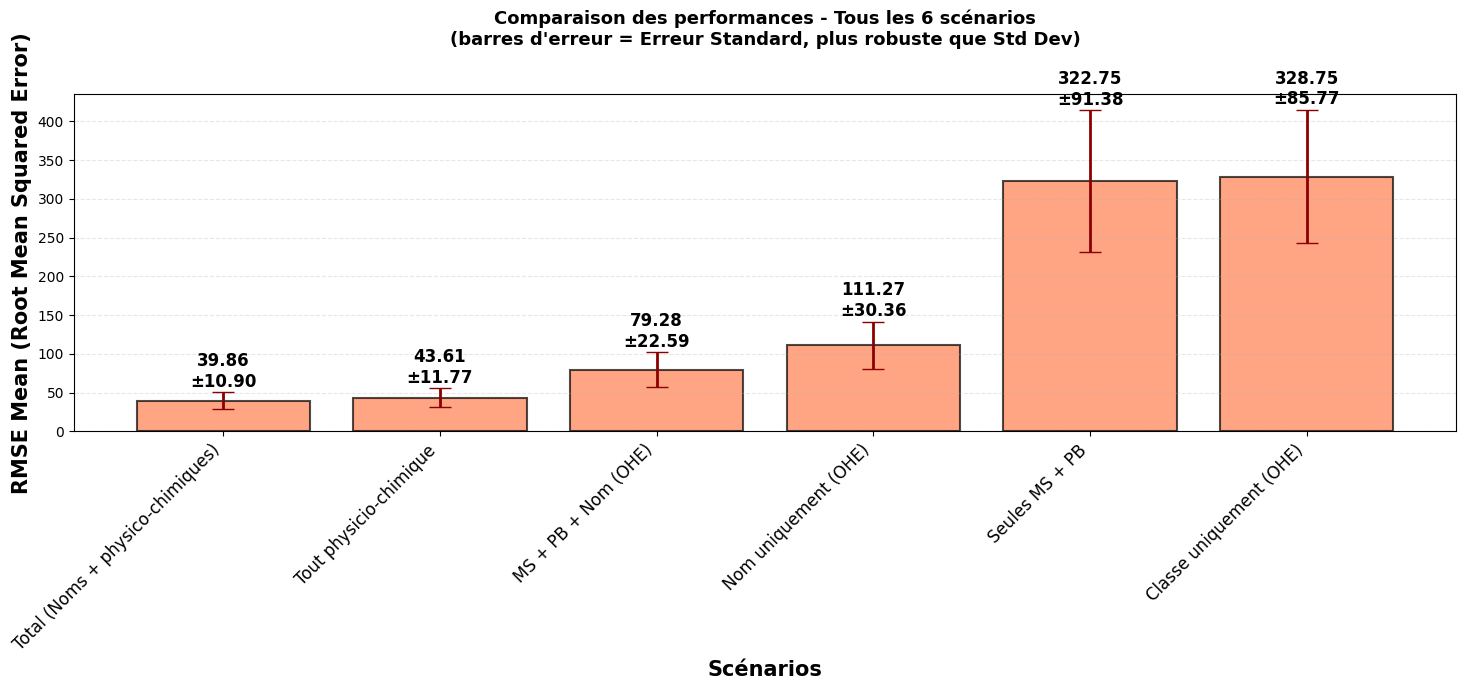

In [87]:
# Même figure mais avec représentation du RMSE à la place du R², pour voir si les tendances sont similaires
# Créer une DataFrame avec RMSE
comparison_rmse_df = pd.DataFrame({
    'Scenario': [
        'Tout physicio-chimique',
        'Seules MS + PB',
        'Nom uniquement (OHE)',
        'Classe uniquement (OHE)',
        'Total (Noms + physico-chimiques)',
        'MS + PB + Nom (OHE)'
    ],
    'RMSE Mean': [
        results_all['RMSE'].mean(),
        results_reduced['RMSE'].mean(),
        results_nom_ohe['RMSE'].mean(),
        results_classe['RMSE'].mean(),
        results_nom['RMSE'].mean(),
        results_mspb_nom['RMSE'].mean()
    ],
    'RMSE Std Dev': [
        results_all['RMSE'].std(),
        results_reduced['RMSE'].std(),
        results_nom_ohe['RMSE'].std(),
        results_classe['RMSE'].std(),
        results_nom['RMSE'].std(),
        results_mspb_nom['RMSE'].std()
    ]
})

# Sort by RMSE in ascending order (lower is better)
comparison_rmse_df = comparison_rmse_df.sort_values('RMSE Mean', ascending=True).reset_index(drop=True)

# Calculer l'erreur standard (plus robuste que l'écart-type brut)
# L'erreur standard = std / sqrt(n) où n = nombre de variables cibles
n_targets = len(vars_cibles)
comparison_rmse_df['RMSE SE'] = comparison_rmse_df['RMSE Std Dev'] / np.sqrt(n_targets)

print("\n" + "="*80)
print("RMSE COMPARISON TABLE (avec Erreur Standard)")
print("="*80)
print(comparison_rmse_df[['Scenario', 'RMSE Mean', 'RMSE Std Dev', 'RMSE SE']].to_string(index=False))

fig, ax = plt.subplots(figsize=(15, 7))
x_pos = np.arange(len(comparison_rmse_df))

# Utiliser l'erreur standard au lieu de l'écart-type pour les barres d'erreur
ax.bar(x_pos, comparison_rmse_df['RMSE Mean'], 
       yerr=comparison_rmse_df['RMSE SE'],
       capsize=8, alpha=0.7, color='coral', edgecolor='black', linewidth=1.5,
       error_kw={'linewidth': 2, 'ecolor': 'darkred'})
ax.set_ylabel('RMSE Mean (Root Mean Squared Error)', fontsize=15, fontweight='bold')
ax.set_xlabel('Scénarios', fontsize=15, fontweight='bold')
ax.set_title('Comparaison des performances - Tous les 6 scénarios\n(barres d\'erreur = Erreur Standard, plus robuste que Std Dev)', 
             fontsize=13, fontweight='bold', pad=35)
ax.set_xticks(x_pos)
ax.set_xticklabels(comparison_rmse_df['Scenario'], fontsize=12, rotation=45, ha='right')
ax.grid(axis='y', alpha=0.3, linestyle='--')

# Add value labels on bars
for i, (val, se) in enumerate(zip(comparison_rmse_df['RMSE Mean'], comparison_rmse_df['RMSE SE'])):
    ax.text(i, val + se + 2, f'{val:.2f}\n±{se:.2f}', 
            ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('../reports/figures/comparison_all_scenarios_rmse.png')
plt.show()

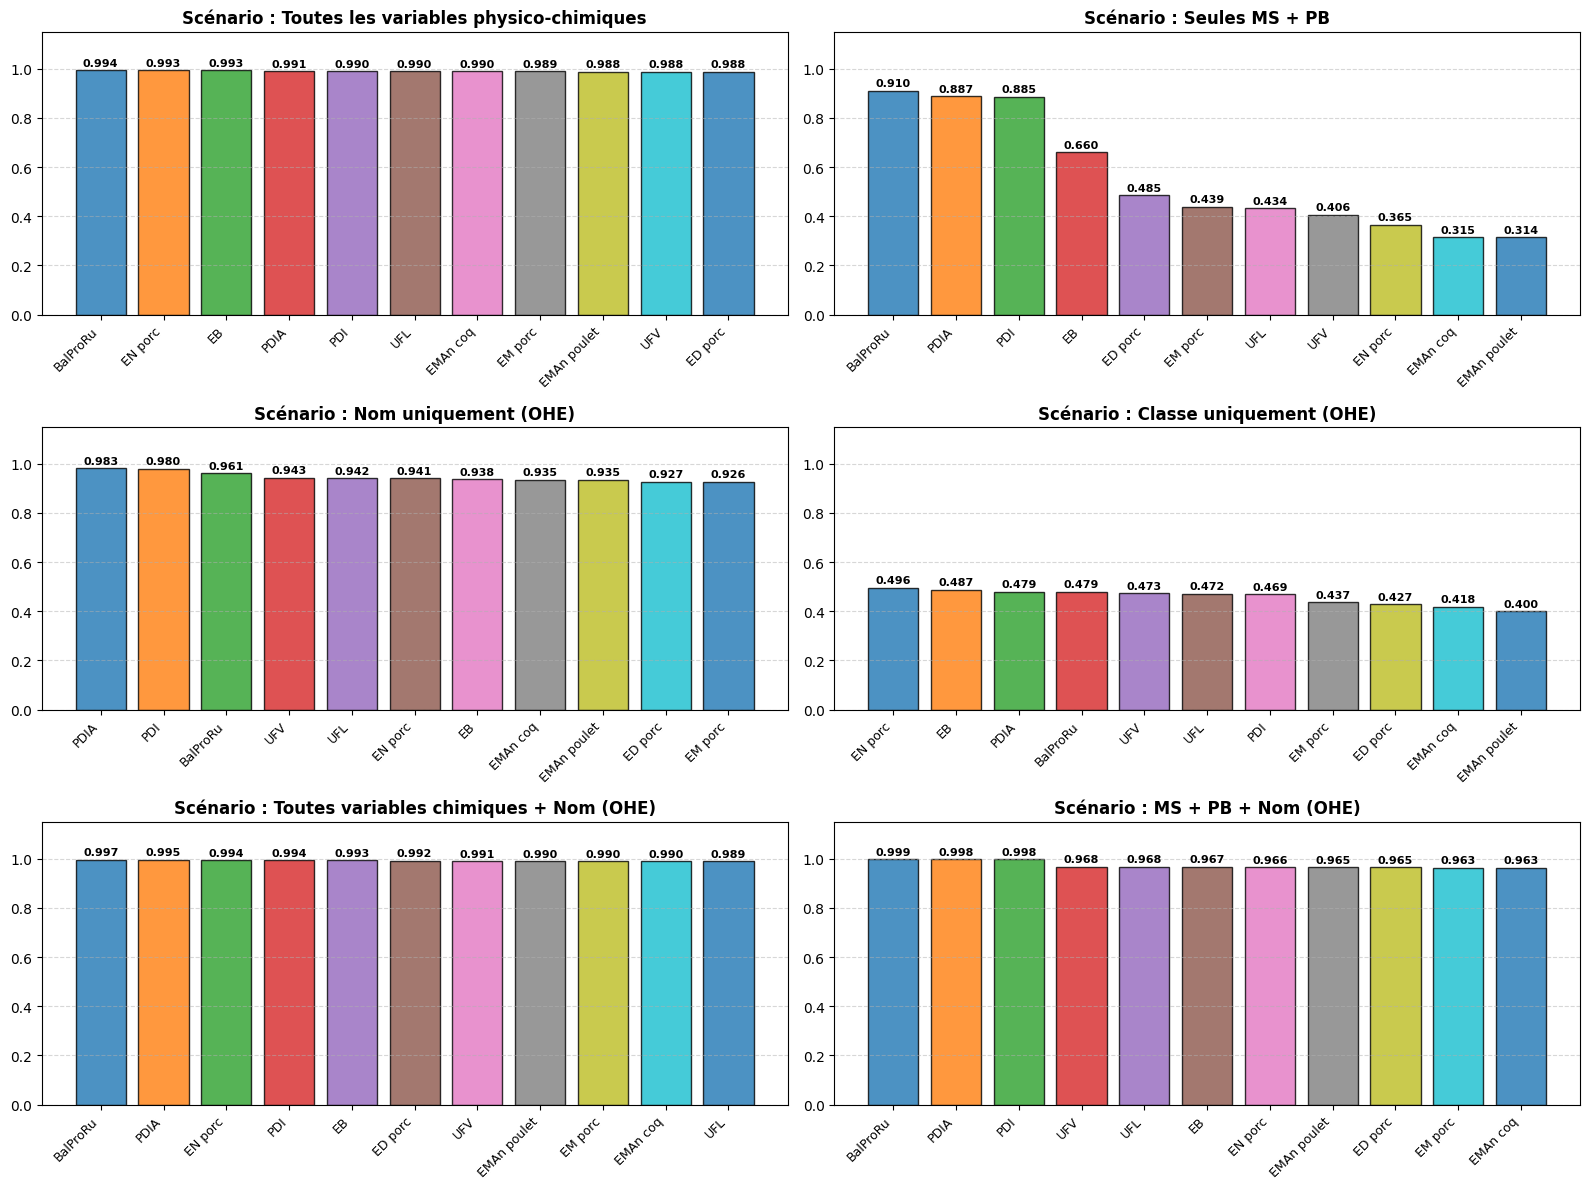

In [84]:
# Grid of R² by target variable for all 6 scenarios
all_detailed_results = {
    'Toutes les variables physico-chimiques': results_all,
    'Seules MS + PB': results_reduced,
    'Nom uniquement (OHE)': results_nom_ohe,
    'Classe uniquement (OHE)': results_classe,
    'Toutes variables chimiques + Nom (OHE)': results_nom,
    'MS + PB + Nom (OHE)': results_mspb_nom
}

# Alternative visualization for detailed results
fig = plot_ml_results(
    all_detailed_results,
    y_col='R2',
    figsize=(16, 12)
)
plt.show()